Pedro Vitor Almeida de Melo - pvam@cesar.school

Link para o dataset = https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small/data

Link para o Drive com o dataset e as imagens - https://drive.google.com/drive/folders/1-HaEnR8iORCdeF--7Ilti8waW8u5RZru?usp=drive_link

Link para train.pt e test.pt - https://drive.google.com/drive/folders/1Stm9ZnPVqn-tIE5sVnjHqcQlRxkI9_oG?usp=sharing

In [43]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [47]:
def train_model(model, trainloader, valloader, criterion, optimizer, device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def show_images(images, titles=None, cols=5):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        img = img.permute(1, 2, 0)
        plt.imshow(img)
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [32]:
# df foi reduzido para 2mil linhas para poder carregar as respectivas imagens no google drive
df = pd.read_csv('/content/drive/MyDrive/RNA e Deep Learning/TF-Dataset/styles.csv', nrows=2000)

In [33]:
df.drop(columns=['season', 'usage', 'baseColour', 'year', 'masterCategory', 'articleType', 'productDisplayName', 'gender'], inplace=True)

In [34]:
# Devido a baixa frequencia irei excluir as labels que aparecem menos que cinco vezes

df = df[df['subCategory'].isin(df['subCategory'].value_counts()[df['subCategory'].value_counts() >=5].index)]
df.reset_index(drop=True, inplace=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1992 entries, 0 to 1991
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1992 non-null   int64 
 1   subCategory  1992 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.3+ KB


In [36]:
path_list = []
for ids in df.id:
  path_list.append('/content/drive/MyDrive/RNA e Deep Learning/TF-Dataset/images/'+str(ids)+'.jpg')

In [39]:
df['path'] = path_list

In [40]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    df['path'],
    df['subCategory'],
    test_size=0.3,
    stratify=df['subCategory'],
    random_state=42
)

In [41]:
df.head()

,id,subCategory,path
0,15970,Topwear,/content/drive/MyDrive/RNA e Deep Learning/TF-...
1,39386,Bottomwear,/content/drive/MyDrive/RNA e Deep Learning/TF-...
2,59263,Watches,/content/drive/MyDrive/RNA e Deep Learning/TF-...
3,21379,Bottomwear,/content/drive/MyDrive/RNA e Deep Learning/TF-...
4,53759,Topwear,/content/drive/MyDrive/RNA e Deep Learning/TF-...


In [44]:
le = LabelEncoder()
labels = le.fit_transform(train_labels.values)

In [45]:
y_train = torch.LongTensor(labels)

In [49]:
labels = le.fit_transform(test_labels.values)
y_test = torch.LongTensor(labels)

# Data Augmentation

<ipython-input-15-456aa8782b20>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(train_path)


Imagens Originais


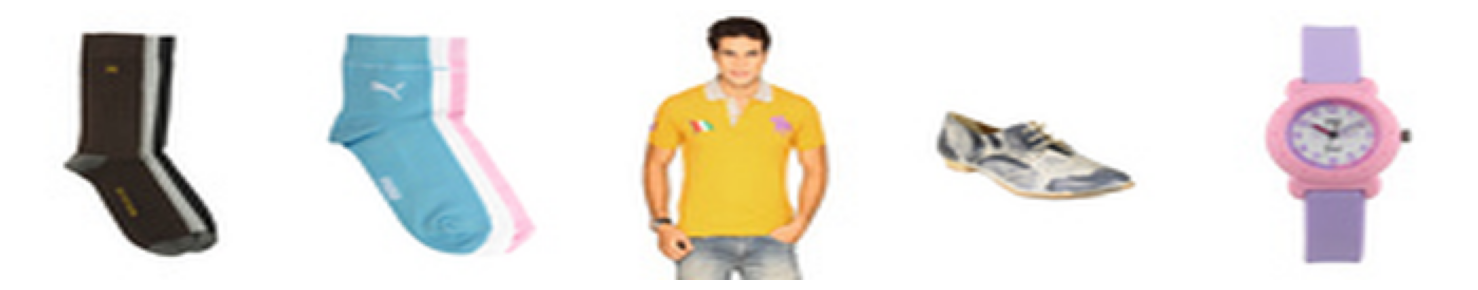

Após ColorJitter


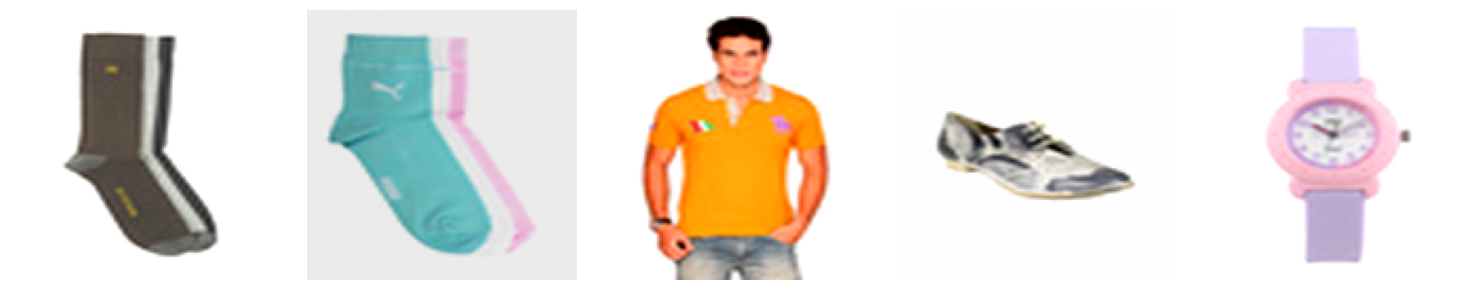

Após GaussianBLur


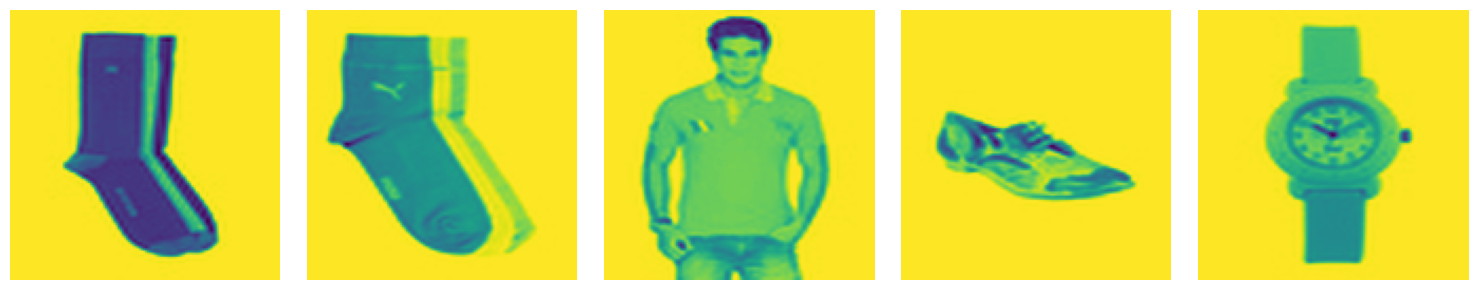

In [15]:
train_path = '/content/train.pt'
val_path = '/content/test.pt'
train_data = torch.load(train_path)
X_train = train_data

example_images = [X_train[i] for i in random.sample(range(len(X_train)), 5)]

# Mostrando imagens originais
print("Imagens Originais")
show_images(example_images)

# Exemplo de ColorJitter
random_solarize = [transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.5, hue=0.05)(img) for img in example_images]
print("Após ColorJitter")
show_images(random_solarize)

# Exemplo de GrayScale
grey_images = [transforms.Grayscale(1)(img) for img in example_images]
print("Após GaussianBLur")
show_images(grey_images)

In [56]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.Resize(256), # Resize images to a common size
    transforms.CenterCrop(224), # Center crop to the desired size (224x224)
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    #transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    #transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set_no_aug = CustomDataset(train_data, y_train, transform=transform_no_aug)
train_set_aug = CustomDataset(train_data, y_train, transform=transform_aug)
val_set = CustomDataset(torch.load(val_path), y_test, transform=transform_no_aug)


train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=True)
train_loader_aug = DataLoader(train_set_aug, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

<ipython-input-56-150feb73eb0e>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val_set = CustomDataset(torch.load(val_path), y_test, transform=transform_no_aug)


In [57]:
len(train_data) == len(y_train)

True

# Construção de Modelo

In [58]:
class CNN(nn.Module):
    def __init__(self, num_classes=28):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=0)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=0)

        self.fc1 = nn.Linear(32 * 2 * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2, stride=2, padding=0)
        x = x.view(-1, 32 * 2 * 2)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN().to(device)

x = torch.randn(1, 3, 224, 224).to(device)
print(model(x).shape)

torch.Size([1, 28])


100%|██████████| 44/44 [00:09<00:00,  4.89it/s]


Epoch 1, Train Loss: 2.881, Train Accuracy: 24.10%
Epoch 1, Val Loss: 2.568, Val Accuracy: 37.79%


100%|██████████| 44/44 [00:06<00:00,  6.53it/s]


Epoch 2, Train Loss: 2.144, Train Accuracy: 44.05%
Epoch 2, Val Loss: 1.754, Val Accuracy: 53.68%


100%|██████████| 44/44 [00:07<00:00,  6.18it/s]


Epoch 3, Train Loss: 1.643, Train Accuracy: 55.95%
Epoch 3, Val Loss: 1.464, Val Accuracy: 61.04%


100%|██████████| 44/44 [00:08<00:00,  5.40it/s]


Epoch 4, Train Loss: 1.377, Train Accuracy: 61.33%
Epoch 4, Val Loss: 1.427, Val Accuracy: 65.05%


100%|██████████| 44/44 [00:06<00:00,  7.31it/s]


Epoch 5, Train Loss: 1.338, Train Accuracy: 62.91%
Epoch 5, Val Loss: 1.205, Val Accuracy: 69.23%


100%|██████████| 44/44 [00:07<00:00,  5.88it/s]


Epoch 6, Train Loss: 1.128, Train Accuracy: 68.51%
Epoch 6, Val Loss: 1.068, Val Accuracy: 74.25%


100%|██████████| 44/44 [00:07<00:00,  5.91it/s]


Epoch 7, Train Loss: 0.938, Train Accuracy: 73.82%
Epoch 7, Val Loss: 0.962, Val Accuracy: 73.08%


100%|██████████| 44/44 [00:06<00:00,  7.11it/s]


Epoch 8, Train Loss: 0.826, Train Accuracy: 75.82%
Epoch 8, Val Loss: 1.012, Val Accuracy: 71.40%


100%|██████████| 44/44 [00:07<00:00,  5.53it/s]


Epoch 9, Train Loss: 0.790, Train Accuracy: 76.90%
Epoch 9, Val Loss: 0.990, Val Accuracy: 75.59%


100%|██████████| 44/44 [00:06<00:00,  6.69it/s]


Epoch 10, Train Loss: 0.722, Train Accuracy: 77.62%
Epoch 10, Val Loss: 0.890, Val Accuracy: 77.42%


100%|██████████| 44/44 [00:06<00:00,  6.51it/s]


Epoch 11, Train Loss: 0.644, Train Accuracy: 81.78%
Epoch 11, Val Loss: 0.921, Val Accuracy: 79.10%


100%|██████████| 44/44 [00:07<00:00,  5.73it/s]


Epoch 12, Train Loss: 0.574, Train Accuracy: 82.78%
Epoch 12, Val Loss: 0.817, Val Accuracy: 81.10%


100%|██████████| 44/44 [00:06<00:00,  7.01it/s]


Epoch 13, Train Loss: 0.528, Train Accuracy: 84.22%
Epoch 13, Val Loss: 0.907, Val Accuracy: 78.60%


100%|██████████| 44/44 [00:07<00:00,  5.58it/s]


Epoch 14, Train Loss: 0.544, Train Accuracy: 83.43%
Epoch 14, Val Loss: 0.826, Val Accuracy: 79.10%


100%|██████████| 44/44 [00:07<00:00,  6.15it/s]


Epoch 15, Train Loss: 0.541, Train Accuracy: 83.57%
Epoch 15, Val Loss: 0.815, Val Accuracy: 78.60%


100%|██████████| 44/44 [00:06<00:00,  6.73it/s]


Epoch 16, Train Loss: 0.447, Train Accuracy: 85.29%
Epoch 16, Val Loss: 0.805, Val Accuracy: 79.43%


100%|██████████| 44/44 [00:08<00:00,  5.44it/s]


Epoch 17, Train Loss: 0.366, Train Accuracy: 87.88%
Epoch 17, Val Loss: 0.993, Val Accuracy: 80.27%


100%|██████████| 44/44 [00:08<00:00,  5.22it/s]


Epoch 18, Train Loss: 0.398, Train Accuracy: 87.37%
Epoch 18, Val Loss: 0.899, Val Accuracy: 75.92%


100%|██████████| 44/44 [00:06<00:00,  6.75it/s]


Epoch 19, Train Loss: 0.397, Train Accuracy: 86.51%
Epoch 19, Val Loss: 1.014, Val Accuracy: 77.42%


100%|██████████| 44/44 [00:07<00:00,  5.76it/s]


Epoch 20, Train Loss: 0.366, Train Accuracy: 88.02%
Epoch 20, Val Loss: 0.897, Val Accuracy: 78.76%


100%|██████████| 44/44 [00:06<00:00,  7.08it/s]


Epoch 21, Train Loss: 0.350, Train Accuracy: 89.10%
Epoch 21, Val Loss: 1.075, Val Accuracy: 71.57%


100%|██████████| 44/44 [00:07<00:00,  5.79it/s]


Epoch 22, Train Loss: 0.303, Train Accuracy: 90.24%
Epoch 22, Val Loss: 1.123, Val Accuracy: 77.26%


100%|██████████| 44/44 [00:07<00:00,  6.11it/s]


Epoch 23, Train Loss: 0.268, Train Accuracy: 91.03%
Epoch 23, Val Loss: 1.170, Val Accuracy: 79.26%


100%|██████████| 44/44 [00:06<00:00,  7.06it/s]


Epoch 24, Train Loss: 0.251, Train Accuracy: 92.04%
Epoch 24, Val Loss: 1.132, Val Accuracy: 81.77%


100%|██████████| 44/44 [00:07<00:00,  5.75it/s]


Epoch 25, Train Loss: 0.255, Train Accuracy: 91.54%
Epoch 25, Val Loss: 1.028, Val Accuracy: 80.43%


100%|██████████| 44/44 [00:06<00:00,  7.03it/s]


Epoch 26, Train Loss: 0.242, Train Accuracy: 92.04%
Epoch 26, Val Loss: 1.158, Val Accuracy: 78.93%


100%|██████████| 44/44 [00:07<00:00,  5.99it/s]


Epoch 27, Train Loss: 0.176, Train Accuracy: 93.62%
Epoch 27, Val Loss: 1.214, Val Accuracy: 79.77%


100%|██████████| 44/44 [00:06<00:00,  6.41it/s]


Epoch 28, Train Loss: 0.183, Train Accuracy: 93.90%
Epoch 28, Val Loss: 1.599, Val Accuracy: 72.58%


100%|██████████| 44/44 [00:06<00:00,  6.87it/s]


Epoch 29, Train Loss: 0.245, Train Accuracy: 92.40%
Epoch 29, Val Loss: 1.186, Val Accuracy: 74.08%


100%|██████████| 44/44 [00:07<00:00,  5.57it/s]


Epoch 30, Train Loss: 0.194, Train Accuracy: 93.04%
Epoch 30, Val Loss: 1.321, Val Accuracy: 78.43%


100%|██████████| 44/44 [00:06<00:00,  6.74it/s]


Epoch 31, Train Loss: 0.131, Train Accuracy: 95.70%
Epoch 31, Val Loss: 1.351, Val Accuracy: 80.43%


100%|██████████| 44/44 [00:07<00:00,  5.63it/s]


Epoch 32, Train Loss: 0.108, Train Accuracy: 96.27%
Epoch 32, Val Loss: 1.659, Val Accuracy: 77.42%


100%|██████████| 44/44 [00:08<00:00,  5.23it/s]


Epoch 33, Train Loss: 0.174, Train Accuracy: 94.84%
Epoch 33, Val Loss: 1.501, Val Accuracy: 78.43%


100%|██████████| 44/44 [00:06<00:00,  6.89it/s]


Epoch 34, Train Loss: 0.209, Train Accuracy: 93.19%
Epoch 34, Val Loss: 1.462, Val Accuracy: 73.24%


100%|██████████| 44/44 [00:07<00:00,  5.56it/s]


Epoch 35, Train Loss: 0.249, Train Accuracy: 92.25%
Epoch 35, Val Loss: 1.281, Val Accuracy: 75.25%


100%|██████████| 44/44 [00:07<00:00,  6.02it/s]


Epoch 36, Train Loss: 0.098, Train Accuracy: 97.06%
Epoch 36, Val Loss: 2.346, Val Accuracy: 77.93%


100%|██████████| 44/44 [00:06<00:00,  7.02it/s]


Epoch 37, Train Loss: 0.204, Train Accuracy: 93.26%
Epoch 37, Val Loss: 1.726, Val Accuracy: 74.25%


100%|██████████| 44/44 [00:07<00:00,  5.50it/s]


Epoch 38, Train Loss: 0.218, Train Accuracy: 93.40%
Epoch 38, Val Loss: 1.247, Val Accuracy: 76.59%


100%|██████████| 44/44 [00:06<00:00,  6.75it/s]


Epoch 39, Train Loss: 0.219, Train Accuracy: 93.62%
Epoch 39, Val Loss: 1.223, Val Accuracy: 76.76%


100%|██████████| 44/44 [00:07<00:00,  5.97it/s]


Epoch 40, Train Loss: 0.163, Train Accuracy: 94.40%
Epoch 40, Val Loss: 1.466, Val Accuracy: 80.77%


100%|██████████| 44/44 [00:07<00:00,  5.94it/s]


Epoch 41, Train Loss: 0.222, Train Accuracy: 92.97%
Epoch 41, Val Loss: 1.675, Val Accuracy: 77.59%


100%|██████████| 44/44 [00:06<00:00,  6.60it/s]


Epoch 42, Train Loss: 0.230, Train Accuracy: 93.04%
Epoch 42, Val Loss: 1.736, Val Accuracy: 77.09%


100%|██████████| 44/44 [00:08<00:00,  5.44it/s]


Epoch 43, Train Loss: 0.228, Train Accuracy: 92.75%
Epoch 43, Val Loss: 1.413, Val Accuracy: 78.09%


100%|██████████| 44/44 [00:07<00:00,  5.78it/s]


Epoch 44, Train Loss: 0.118, Train Accuracy: 95.77%
Epoch 44, Val Loss: 1.671, Val Accuracy: 78.09%


100%|██████████| 44/44 [00:06<00:00,  7.13it/s]


Epoch 45, Train Loss: 0.113, Train Accuracy: 96.70%
Epoch 45, Val Loss: 1.843, Val Accuracy: 78.09%


100%|██████████| 44/44 [00:07<00:00,  5.82it/s]


Epoch 46, Train Loss: 0.260, Train Accuracy: 92.25%
Epoch 46, Val Loss: 2.329, Val Accuracy: 76.59%


100%|██████████| 44/44 [00:06<00:00,  7.30it/s]


Epoch 47, Train Loss: 0.280, Train Accuracy: 92.11%
Epoch 47, Val Loss: 1.396, Val Accuracy: 74.25%


100%|██████████| 44/44 [00:07<00:00,  5.51it/s]


Epoch 48, Train Loss: 0.151, Train Accuracy: 95.62%
Epoch 48, Val Loss: 1.554, Val Accuracy: 77.93%


100%|██████████| 44/44 [00:07<00:00,  5.71it/s]


Epoch 49, Train Loss: 0.140, Train Accuracy: 95.48%
Epoch 49, Val Loss: 1.982, Val Accuracy: 74.92%


100%|██████████| 44/44 [00:06<00:00,  7.07it/s]


Epoch 50, Train Loss: 0.127, Train Accuracy: 95.77%
Epoch 50, Val Loss: 1.631, Val Accuracy: 78.26%
Treinamento concluído


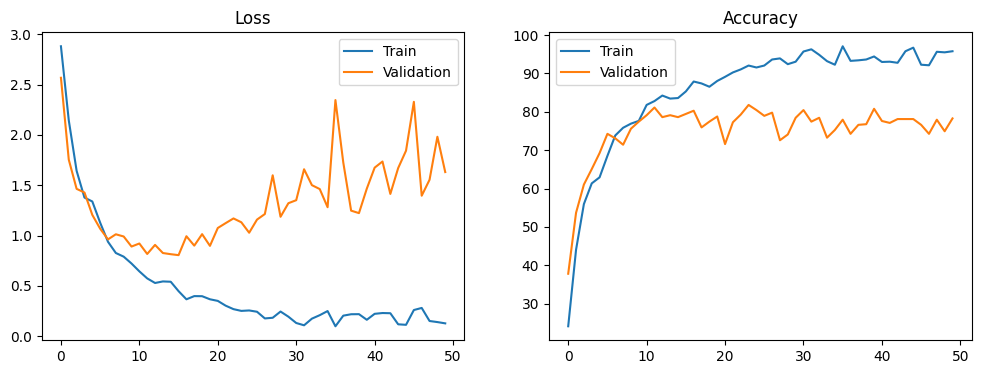

In [59]:
model_no_aug = CNN().to(device)

criterion_no_aug = nn.CrossEntropyLoss()
optimizer_no_aug = optim.SGD(model_no_aug.parameters(), lr=0.01, momentum=0.9)

history_no_aug = train_model(model_no_aug, train_loader_no_aug, val_loader, criterion_no_aug, optimizer_no_aug, device, num_epochs=50)

plot_history(history_no_aug)

100%|██████████| 44/44 [00:27<00:00,  1.60it/s]


Epoch 1, Train Loss: 2.839, Train Accuracy: 30.99%
Epoch 1, Val Loss: 2.667, Val Accuracy: 35.45%


100%|██████████| 44/44 [00:28<00:00,  1.54it/s]


Epoch 2, Train Loss: 2.204, Train Accuracy: 45.91%
Epoch 2, Val Loss: 2.022, Val Accuracy: 48.33%


100%|██████████| 44/44 [00:26<00:00,  1.66it/s]


Epoch 3, Train Loss: 1.758, Train Accuracy: 53.01%
Epoch 3, Val Loss: 1.493, Val Accuracy: 56.86%


100%|██████████| 44/44 [00:26<00:00,  1.66it/s]


Epoch 4, Train Loss: 1.515, Train Accuracy: 58.75%
Epoch 4, Val Loss: 1.538, Val Accuracy: 58.03%


100%|██████████| 44/44 [00:27<00:00,  1.62it/s]


Epoch 5, Train Loss: 1.318, Train Accuracy: 63.06%
Epoch 5, Val Loss: 1.387, Val Accuracy: 61.71%


100%|██████████| 44/44 [00:26<00:00,  1.63it/s]


Epoch 6, Train Loss: 1.184, Train Accuracy: 65.85%
Epoch 6, Val Loss: 1.230, Val Accuracy: 66.22%


100%|██████████| 44/44 [00:27<00:00,  1.62it/s]


Epoch 7, Train Loss: 1.000, Train Accuracy: 70.52%
Epoch 7, Val Loss: 1.343, Val Accuracy: 63.71%


100%|██████████| 44/44 [00:26<00:00,  1.65it/s]


Epoch 8, Train Loss: 0.985, Train Accuracy: 71.23%
Epoch 8, Val Loss: 1.182, Val Accuracy: 65.22%


100%|██████████| 44/44 [00:27<00:00,  1.62it/s]


Epoch 9, Train Loss: 0.907, Train Accuracy: 74.18%
Epoch 9, Val Loss: 1.277, Val Accuracy: 67.39%


100%|██████████| 44/44 [00:26<00:00,  1.63it/s]


Epoch 10, Train Loss: 0.810, Train Accuracy: 76.97%
Epoch 10, Val Loss: 1.090, Val Accuracy: 71.91%


100%|██████████| 44/44 [00:27<00:00,  1.58it/s]


Epoch 11, Train Loss: 0.711, Train Accuracy: 78.77%
Epoch 11, Val Loss: 1.108, Val Accuracy: 70.90%


100%|██████████| 44/44 [00:27<00:00,  1.60it/s]


Epoch 12, Train Loss: 0.769, Train Accuracy: 76.90%
Epoch 12, Val Loss: 1.238, Val Accuracy: 70.07%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 13, Train Loss: 0.671, Train Accuracy: 80.13%
Epoch 13, Val Loss: 1.003, Val Accuracy: 73.24%


100%|██████████| 44/44 [00:26<00:00,  1.63it/s]


Epoch 14, Train Loss: 0.633, Train Accuracy: 79.77%
Epoch 14, Val Loss: 1.045, Val Accuracy: 68.56%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 15, Train Loss: 0.562, Train Accuracy: 81.85%
Epoch 15, Val Loss: 0.997, Val Accuracy: 74.08%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 16, Train Loss: 0.538, Train Accuracy: 83.14%
Epoch 16, Val Loss: 1.302, Val Accuracy: 72.24%


100%|██████████| 44/44 [00:26<00:00,  1.63it/s]


Epoch 17, Train Loss: 0.518, Train Accuracy: 85.44%
Epoch 17, Val Loss: 1.104, Val Accuracy: 69.40%


100%|██████████| 44/44 [00:26<00:00,  1.66it/s]


Epoch 18, Train Loss: 0.482, Train Accuracy: 83.57%
Epoch 18, Val Loss: 1.283, Val Accuracy: 72.24%


100%|██████████| 44/44 [00:25<00:00,  1.71it/s]


Epoch 19, Train Loss: 0.448, Train Accuracy: 86.30%
Epoch 19, Val Loss: 1.284, Val Accuracy: 70.40%


100%|██████████| 44/44 [00:27<00:00,  1.60it/s]


Epoch 20, Train Loss: 0.436, Train Accuracy: 86.30%
Epoch 20, Val Loss: 1.171, Val Accuracy: 73.91%


100%|██████████| 44/44 [00:25<00:00,  1.72it/s]


Epoch 21, Train Loss: 0.421, Train Accuracy: 86.59%
Epoch 21, Val Loss: 1.426, Val Accuracy: 71.91%


100%|██████████| 44/44 [00:26<00:00,  1.67it/s]


Epoch 22, Train Loss: 0.375, Train Accuracy: 88.74%
Epoch 22, Val Loss: 1.555, Val Accuracy: 72.07%


100%|██████████| 44/44 [00:26<00:00,  1.66it/s]


Epoch 23, Train Loss: 0.310, Train Accuracy: 90.03%
Epoch 23, Val Loss: 1.380, Val Accuracy: 74.41%


100%|██████████| 44/44 [00:26<00:00,  1.67it/s]


Epoch 24, Train Loss: 0.340, Train Accuracy: 90.10%
Epoch 24, Val Loss: 1.157, Val Accuracy: 73.41%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 25, Train Loss: 0.317, Train Accuracy: 90.46%
Epoch 25, Val Loss: 1.392, Val Accuracy: 70.90%


100%|██████████| 44/44 [00:26<00:00,  1.65it/s]


Epoch 26, Train Loss: 0.301, Train Accuracy: 90.24%
Epoch 26, Val Loss: 1.213, Val Accuracy: 74.75%


100%|██████████| 44/44 [00:26<00:00,  1.66it/s]


Epoch 27, Train Loss: 0.262, Train Accuracy: 91.25%
Epoch 27, Val Loss: 1.295, Val Accuracy: 74.75%


100%|██████████| 44/44 [00:26<00:00,  1.66it/s]


Epoch 28, Train Loss: 0.328, Train Accuracy: 89.60%
Epoch 28, Val Loss: 1.573, Val Accuracy: 62.88%


100%|██████████| 44/44 [00:26<00:00,  1.65it/s]


Epoch 29, Train Loss: 0.343, Train Accuracy: 89.10%
Epoch 29, Val Loss: 1.622, Val Accuracy: 74.41%


100%|██████████| 44/44 [00:27<00:00,  1.63it/s]


Epoch 30, Train Loss: 0.317, Train Accuracy: 90.82%
Epoch 30, Val Loss: 1.052, Val Accuracy: 73.75%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 31, Train Loss: 0.235, Train Accuracy: 92.68%
Epoch 31, Val Loss: 2.136, Val Accuracy: 73.41%


100%|██████████| 44/44 [00:26<00:00,  1.65it/s]


Epoch 32, Train Loss: 0.242, Train Accuracy: 91.97%
Epoch 32, Val Loss: 1.580, Val Accuracy: 75.59%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 33, Train Loss: 0.176, Train Accuracy: 93.76%
Epoch 33, Val Loss: 1.855, Val Accuracy: 75.59%


100%|██████████| 44/44 [00:25<00:00,  1.69it/s]


Epoch 34, Train Loss: 0.392, Train Accuracy: 88.67%
Epoch 34, Val Loss: 1.611, Val Accuracy: 69.23%


100%|██████████| 44/44 [00:25<00:00,  1.74it/s]


Epoch 35, Train Loss: 0.361, Train Accuracy: 89.67%
Epoch 35, Val Loss: 1.568, Val Accuracy: 74.58%


100%|██████████| 44/44 [00:26<00:00,  1.69it/s]


Epoch 36, Train Loss: 0.239, Train Accuracy: 91.75%
Epoch 36, Val Loss: 1.429, Val Accuracy: 72.58%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 37, Train Loss: 0.187, Train Accuracy: 94.55%
Epoch 37, Val Loss: 1.600, Val Accuracy: 72.91%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 38, Train Loss: 0.298, Train Accuracy: 91.18%
Epoch 38, Val Loss: 1.539, Val Accuracy: 71.24%


100%|██████████| 44/44 [00:26<00:00,  1.66it/s]


Epoch 39, Train Loss: 0.200, Train Accuracy: 92.90%
Epoch 39, Val Loss: 1.834, Val Accuracy: 73.75%


100%|██████████| 44/44 [00:26<00:00,  1.66it/s]


Epoch 40, Train Loss: 0.245, Train Accuracy: 92.47%
Epoch 40, Val Loss: 1.231, Val Accuracy: 72.74%


100%|██████████| 44/44 [00:26<00:00,  1.65it/s]


Epoch 41, Train Loss: 0.203, Train Accuracy: 93.26%
Epoch 41, Val Loss: 1.610, Val Accuracy: 73.41%


100%|██████████| 44/44 [00:26<00:00,  1.65it/s]


Epoch 42, Train Loss: 0.217, Train Accuracy: 94.26%
Epoch 42, Val Loss: 2.035, Val Accuracy: 74.75%


100%|██████████| 44/44 [00:26<00:00,  1.67it/s]


Epoch 43, Train Loss: 0.201, Train Accuracy: 93.62%
Epoch 43, Val Loss: 1.630, Val Accuracy: 72.07%


100%|██████████| 44/44 [00:26<00:00,  1.68it/s]


Epoch 44, Train Loss: 0.185, Train Accuracy: 93.97%
Epoch 44, Val Loss: 2.420, Val Accuracy: 72.24%


100%|██████████| 44/44 [00:25<00:00,  1.74it/s]


Epoch 45, Train Loss: 0.151, Train Accuracy: 95.62%
Epoch 45, Val Loss: 1.728, Val Accuracy: 73.08%


100%|██████████| 44/44 [00:26<00:00,  1.65it/s]


Epoch 46, Train Loss: 0.111, Train Accuracy: 96.92%
Epoch 46, Val Loss: 1.948, Val Accuracy: 73.41%


100%|██████████| 44/44 [00:25<00:00,  1.69it/s]


Epoch 47, Train Loss: 0.116, Train Accuracy: 96.41%
Epoch 47, Val Loss: 1.915, Val Accuracy: 73.08%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 48, Train Loss: 0.135, Train Accuracy: 95.70%
Epoch 48, Val Loss: 1.904, Val Accuracy: 72.91%


100%|██████████| 44/44 [00:25<00:00,  1.70it/s]


Epoch 49, Train Loss: 0.135, Train Accuracy: 95.84%
Epoch 49, Val Loss: 1.770, Val Accuracy: 73.75%


100%|██████████| 44/44 [00:26<00:00,  1.67it/s]


Epoch 50, Train Loss: 0.191, Train Accuracy: 94.48%
Epoch 50, Val Loss: 2.760, Val Accuracy: 73.41%
Treinamento concluído


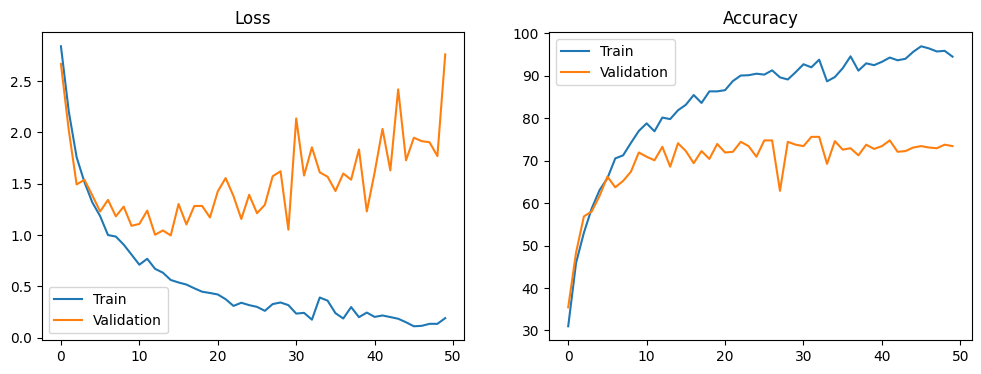

In [60]:
model_aug = CNN().to(device)

criterion_aug = nn.CrossEntropyLoss()
optimizer_aug = optim.SGD(model_aug.parameters(), lr=0.01, momentum=0.9)

history_aug = train_model(model_aug, train_loader_aug, val_loader, criterion_aug, optimizer_aug, device, num_epochs=50)

plot_history(history_aug)

# Congelamento de Camadas

In [61]:
for param in model.conv1.parameters():
    param.requires_grad = False

# Optionally, print which parameters are frozen
print("Trainable parameters:")
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

Trainable parameters:
conv1.weight: requires_grad=False
conv1.bias: requires_grad=False
conv2.weight: requires_grad=True
conv2.bias: requires_grad=True
conv3.weight: requires_grad=True
conv3.bias: requires_grad=True
fc1.weight: requires_grad=True
fc1.bias: requires_grad=True
fc2.weight: requires_grad=True
fc2.bias: requires_grad=True
fc3.weight: requires_grad=True
fc3.bias: requires_grad=True


100%|██████████| 44/44 [00:06<00:00,  6.92it/s]


Epoch 1, Train Loss: 0.090, Train Accuracy: 97.42%
Epoch 1, Val Loss: 1.589, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:08<00:00,  5.38it/s]


Epoch 2, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 2, Val Loss: 1.646, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  6.04it/s]


Epoch 3, Train Loss: 0.088, Train Accuracy: 97.42%
Epoch 3, Val Loss: 1.596, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  6.22it/s]


Epoch 4, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 4, Val Loss: 1.612, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  5.79it/s]


Epoch 5, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 5, Val Loss: 1.599, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  5.57it/s]


Epoch 6, Train Loss: 0.090, Train Accuracy: 97.42%
Epoch 6, Val Loss: 1.622, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  5.77it/s]


Epoch 7, Train Loss: 0.088, Train Accuracy: 97.42%
Epoch 7, Val Loss: 1.613, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  5.68it/s]


Epoch 8, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 8, Val Loss: 1.590, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  6.10it/s]


Epoch 9, Train Loss: 0.088, Train Accuracy: 97.42%
Epoch 9, Val Loss: 1.610, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:06<00:00,  6.87it/s]


Epoch 10, Train Loss: 0.088, Train Accuracy: 97.42%
Epoch 10, Val Loss: 1.604, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  5.74it/s]


Epoch 11, Train Loss: 0.088, Train Accuracy: 97.42%
Epoch 11, Val Loss: 1.601, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:09<00:00,  4.76it/s]


Epoch 12, Train Loss: 0.088, Train Accuracy: 97.42%
Epoch 12, Val Loss: 1.597, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  6.28it/s]


Epoch 13, Train Loss: 0.088, Train Accuracy: 97.42%
Epoch 13, Val Loss: 1.604, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  5.76it/s]


Epoch 14, Train Loss: 0.088, Train Accuracy: 97.42%
Epoch 14, Val Loss: 1.598, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:06<00:00,  7.20it/s]


Epoch 15, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 15, Val Loss: 1.609, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  5.81it/s]


Epoch 16, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 16, Val Loss: 1.631, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:06<00:00,  7.19it/s]


Epoch 17, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 17, Val Loss: 1.609, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  5.85it/s]


Epoch 18, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 18, Val Loss: 1.612, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:08<00:00,  5.07it/s]


Epoch 19, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 19, Val Loss: 1.603, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:06<00:00,  7.24it/s]


Epoch 20, Train Loss: 0.090, Train Accuracy: 97.42%
Epoch 20, Val Loss: 1.592, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  5.81it/s]


Epoch 21, Train Loss: 0.090, Train Accuracy: 97.42%
Epoch 21, Val Loss: 1.606, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:06<00:00,  7.23it/s]


Epoch 22, Train Loss: 0.090, Train Accuracy: 97.42%
Epoch 22, Val Loss: 1.625, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  6.28it/s]


Epoch 23, Train Loss: 0.088, Train Accuracy: 97.42%
Epoch 23, Val Loss: 1.617, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  6.23it/s]


Epoch 24, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 24, Val Loss: 1.634, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:06<00:00,  7.20it/s]


Epoch 25, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 25, Val Loss: 1.602, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  5.76it/s]


Epoch 26, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 26, Val Loss: 1.633, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:06<00:00,  6.79it/s]


Epoch 27, Train Loss: 0.090, Train Accuracy: 97.42%
Epoch 27, Val Loss: 1.594, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:06<00:00,  6.39it/s]


Epoch 28, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 28, Val Loss: 1.592, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  6.25it/s]


Epoch 29, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 29, Val Loss: 1.589, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:06<00:00,  7.09it/s]


Epoch 30, Train Loss: 0.088, Train Accuracy: 97.42%
Epoch 30, Val Loss: 1.606, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  5.86it/s]


Epoch 31, Train Loss: 0.088, Train Accuracy: 97.42%
Epoch 31, Val Loss: 1.588, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:06<00:00,  7.20it/s]


Epoch 32, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 32, Val Loss: 1.601, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  5.90it/s]


Epoch 33, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 33, Val Loss: 1.582, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  5.99it/s]


Epoch 34, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 34, Val Loss: 1.618, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:06<00:00,  6.81it/s]


Epoch 35, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 35, Val Loss: 1.600, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  5.56it/s]


Epoch 36, Train Loss: 0.090, Train Accuracy: 97.42%
Epoch 36, Val Loss: 1.601, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:06<00:00,  6.72it/s]


Epoch 37, Train Loss: 0.090, Train Accuracy: 97.42%
Epoch 37, Val Loss: 1.611, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:08<00:00,  5.50it/s]


Epoch 38, Train Loss: 0.088, Train Accuracy: 97.42%
Epoch 38, Val Loss: 1.614, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:06<00:00,  6.55it/s]


Epoch 39, Train Loss: 0.088, Train Accuracy: 97.42%
Epoch 39, Val Loss: 1.592, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:06<00:00,  6.60it/s]


Epoch 40, Train Loss: 0.090, Train Accuracy: 97.42%
Epoch 40, Val Loss: 1.597, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  5.62it/s]


Epoch 41, Train Loss: 0.091, Train Accuracy: 97.42%
Epoch 41, Val Loss: 1.610, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  6.11it/s]


Epoch 42, Train Loss: 0.088, Train Accuracy: 97.42%
Epoch 42, Val Loss: 1.602, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:06<00:00,  7.14it/s]


Epoch 43, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 43, Val Loss: 1.602, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  5.63it/s]


Epoch 44, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 44, Val Loss: 1.588, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:06<00:00,  7.16it/s]


Epoch 45, Train Loss: 0.090, Train Accuracy: 97.42%
Epoch 45, Val Loss: 1.584, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:08<00:00,  5.31it/s]


Epoch 46, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 46, Val Loss: 1.588, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:06<00:00,  6.80it/s]


Epoch 47, Train Loss: 0.088, Train Accuracy: 97.42%
Epoch 47, Val Loss: 1.602, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  5.83it/s]


Epoch 48, Train Loss: 0.088, Train Accuracy: 97.42%
Epoch 48, Val Loss: 1.609, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:07<00:00,  5.57it/s]


Epoch 49, Train Loss: 0.088, Train Accuracy: 97.42%
Epoch 49, Val Loss: 1.597, Val Accuracy: 78.26%


100%|██████████| 44/44 [00:06<00:00,  7.18it/s]


Epoch 50, Train Loss: 0.089, Train Accuracy: 97.42%
Epoch 50, Val Loss: 1.612, Val Accuracy: 78.26%
Treinamento concluído


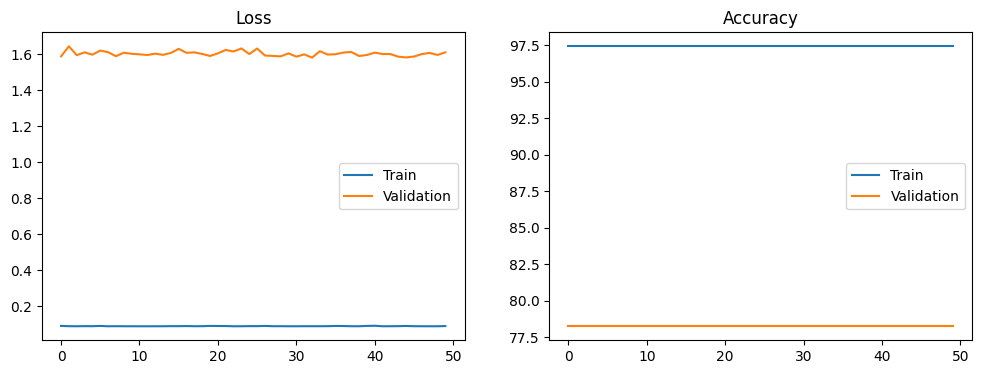

In [64]:
criterion_no_aug = nn.CrossEntropyLoss()
optimizer_no_aug = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

history_no_aug = train_model(model_no_aug, train_loader_no_aug, val_loader, criterion_no_aug, optimizer_no_aug, device, num_epochs=50)

plot_history(history_no_aug)

100%|██████████| 44/44 [00:26<00:00,  1.66it/s]


Epoch 1, Train Loss: 0.571, Train Accuracy: 81.78%
Epoch 1, Val Loss: 1.468, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.67it/s]


Epoch 2, Train Loss: 0.559, Train Accuracy: 81.85%
Epoch 2, Val Loss: 1.462, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:27<00:00,  1.59it/s]


Epoch 3, Train Loss: 0.578, Train Accuracy: 81.92%
Epoch 3, Val Loss: 1.476, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:27<00:00,  1.59it/s]


Epoch 4, Train Loss: 0.576, Train Accuracy: 82.14%
Epoch 4, Val Loss: 1.475, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.67it/s]


Epoch 5, Train Loss: 0.579, Train Accuracy: 81.13%
Epoch 5, Val Loss: 1.462, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 6, Train Loss: 0.587, Train Accuracy: 80.99%
Epoch 6, Val Loss: 1.462, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 7, Train Loss: 0.592, Train Accuracy: 80.70%
Epoch 7, Val Loss: 1.465, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:27<00:00,  1.60it/s]


Epoch 8, Train Loss: 0.568, Train Accuracy: 81.64%
Epoch 8, Val Loss: 1.492, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:27<00:00,  1.61it/s]


Epoch 9, Train Loss: 0.573, Train Accuracy: 81.78%
Epoch 9, Val Loss: 1.467, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:27<00:00,  1.62it/s]


Epoch 10, Train Loss: 0.577, Train Accuracy: 82.07%
Epoch 10, Val Loss: 1.461, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:27<00:00,  1.63it/s]


Epoch 11, Train Loss: 0.580, Train Accuracy: 81.64%
Epoch 11, Val Loss: 1.464, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.63it/s]


Epoch 12, Train Loss: 0.579, Train Accuracy: 81.64%
Epoch 12, Val Loss: 1.466, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 13, Train Loss: 0.585, Train Accuracy: 81.49%
Epoch 13, Val Loss: 1.460, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 14, Train Loss: 0.569, Train Accuracy: 82.64%
Epoch 14, Val Loss: 1.459, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.67it/s]


Epoch 15, Train Loss: 0.570, Train Accuracy: 81.78%
Epoch 15, Val Loss: 1.476, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:25<00:00,  1.72it/s]


Epoch 16, Train Loss: 0.576, Train Accuracy: 81.64%
Epoch 16, Val Loss: 1.483, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.69it/s]


Epoch 17, Train Loss: 0.586, Train Accuracy: 81.06%
Epoch 17, Val Loss: 1.461, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.65it/s]


Epoch 18, Train Loss: 0.575, Train Accuracy: 81.28%
Epoch 18, Val Loss: 1.464, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:27<00:00,  1.58it/s]


Epoch 19, Train Loss: 0.582, Train Accuracy: 81.64%
Epoch 19, Val Loss: 1.488, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 20, Train Loss: 0.579, Train Accuracy: 81.35%
Epoch 20, Val Loss: 1.469, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.66it/s]


Epoch 21, Train Loss: 0.588, Train Accuracy: 80.99%
Epoch 21, Val Loss: 1.460, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.65it/s]


Epoch 22, Train Loss: 0.576, Train Accuracy: 81.28%
Epoch 22, Val Loss: 1.469, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.65it/s]


Epoch 23, Train Loss: 0.582, Train Accuracy: 81.64%
Epoch 23, Val Loss: 1.472, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.65it/s]


Epoch 24, Train Loss: 0.576, Train Accuracy: 80.77%
Epoch 24, Val Loss: 1.461, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.63it/s]


Epoch 25, Train Loss: 0.577, Train Accuracy: 81.35%
Epoch 25, Val Loss: 1.471, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 26, Train Loss: 0.572, Train Accuracy: 82.14%
Epoch 26, Val Loss: 1.473, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.65it/s]


Epoch 27, Train Loss: 0.584, Train Accuracy: 80.56%
Epoch 27, Val Loss: 1.483, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.65it/s]


Epoch 28, Train Loss: 0.563, Train Accuracy: 81.42%
Epoch 28, Val Loss: 1.484, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.65it/s]


Epoch 29, Train Loss: 0.575, Train Accuracy: 81.85%
Epoch 29, Val Loss: 1.472, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 30, Train Loss: 0.576, Train Accuracy: 81.13%
Epoch 30, Val Loss: 1.463, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.66it/s]


Epoch 31, Train Loss: 0.580, Train Accuracy: 81.28%
Epoch 31, Val Loss: 1.471, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:27<00:00,  1.63it/s]


Epoch 32, Train Loss: 0.581, Train Accuracy: 81.35%
Epoch 32, Val Loss: 1.472, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:25<00:00,  1.72it/s]


Epoch 33, Train Loss: 0.578, Train Accuracy: 80.99%
Epoch 33, Val Loss: 1.473, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.68it/s]


Epoch 34, Train Loss: 0.584, Train Accuracy: 81.78%
Epoch 34, Val Loss: 1.466, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.65it/s]


Epoch 35, Train Loss: 0.579, Train Accuracy: 80.85%
Epoch 35, Val Loss: 1.469, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 36, Train Loss: 0.578, Train Accuracy: 81.13%
Epoch 36, Val Loss: 1.485, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 37, Train Loss: 0.576, Train Accuracy: 80.92%
Epoch 37, Val Loss: 1.481, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.63it/s]


Epoch 38, Train Loss: 0.576, Train Accuracy: 81.64%
Epoch 38, Val Loss: 1.471, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 39, Train Loss: 0.577, Train Accuracy: 81.42%
Epoch 39, Val Loss: 1.461, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:27<00:00,  1.62it/s]


Epoch 40, Train Loss: 0.578, Train Accuracy: 81.06%
Epoch 40, Val Loss: 1.458, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 41, Train Loss: 0.584, Train Accuracy: 80.70%
Epoch 41, Val Loss: 1.462, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:27<00:00,  1.60it/s]


Epoch 42, Train Loss: 0.584, Train Accuracy: 81.85%
Epoch 42, Val Loss: 1.468, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:27<00:00,  1.62it/s]


Epoch 43, Train Loss: 0.578, Train Accuracy: 80.70%
Epoch 43, Val Loss: 1.470, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.66it/s]


Epoch 44, Train Loss: 0.582, Train Accuracy: 81.99%
Epoch 44, Val Loss: 1.462, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:25<00:00,  1.71it/s]


Epoch 45, Train Loss: 0.574, Train Accuracy: 81.42%
Epoch 45, Val Loss: 1.467, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.69it/s]


Epoch 46, Train Loss: 0.581, Train Accuracy: 80.99%
Epoch 46, Val Loss: 1.477, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.68it/s]


Epoch 47, Train Loss: 0.589, Train Accuracy: 80.27%
Epoch 47, Val Loss: 1.488, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Epoch 48, Train Loss: 0.571, Train Accuracy: 81.42%
Epoch 48, Val Loss: 1.472, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.66it/s]


Epoch 49, Train Loss: 0.590, Train Accuracy: 81.21%
Epoch 49, Val Loss: 1.489, Val Accuracy: 66.56%


100%|██████████| 44/44 [00:26<00:00,  1.65it/s]


Epoch 50, Train Loss: 0.585, Train Accuracy: 81.71%
Epoch 50, Val Loss: 1.472, Val Accuracy: 66.56%
Treinamento concluído


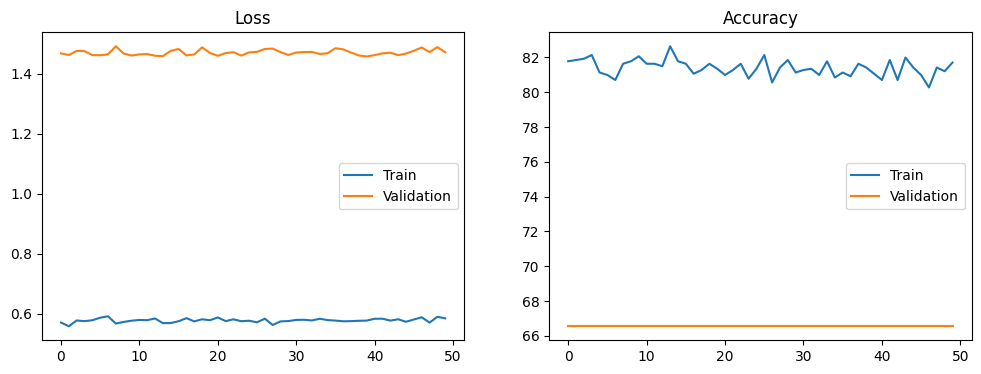

In [63]:
optimizer_aug = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)
criterion_aug = nn.CrossEntropyLoss()

history_aug = train_model(model_aug, train_loader_aug, val_loader, criterion_aug, optimizer_aug, device, num_epochs=50)
plot_history(history_aug)